In [1]:
import warnings

import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted
# Import libraries here
import gzip
import json
import pickle
import pandas as pd

import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
df = pd.read_excel(r"C:\Users\hp\WorldQuantum\Atmos\data sources\lon-lat.xlsx")
# Convert 'lat' values to the desired format
df['lat'] = df['lat'].astype(str).str[:2] + '.' + df['lat'].astype(str).str[2:]
# Remove the last character from 'lon' values
df['lon'] = df['lon'].str.rstrip(')')
df = df.astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lat           399 non-null    float64
 1   lon           399 non-null    float64
 2   Milliseconds  399 non-null    float64
 3   Events        399 non-null    float64
dtypes: float64(4)
memory usage: 12.6 KB


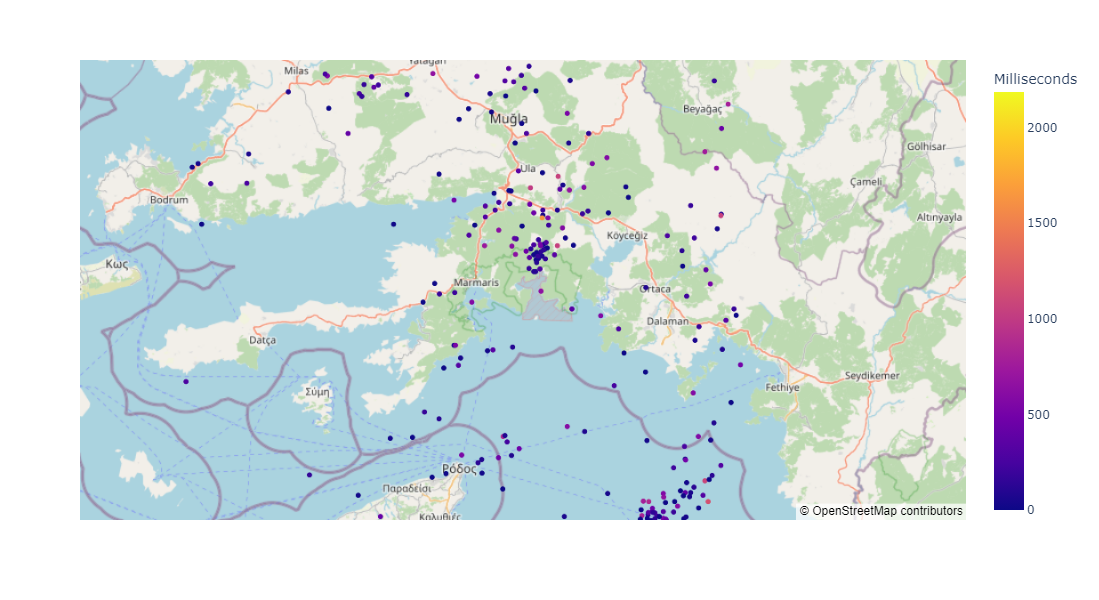

In [3]:
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat='lat',
    lon='lon',
    width=600,  # Width of map
    height=600,  # Height of map
    color='Milliseconds',
    hover_data=["Events"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

In [4]:
df = pd.read_csv(r"C:\Users\hp\WorldQuantum\Atmos\data sources\Flash-Mugla.csv")
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.set_index('Date', inplace=True)
df["Event"] = df["Event"].map({0: False, 1: True})
df

SL        SST   Air-Temp   Tot-Prec  Event
Date                                                        
2014-01-01  0.071491  17.514221  10.124750   0.079488  False
2014-01-02  0.078008  17.512387   8.732660  14.801616   True
2014-01-03  0.079241  17.378781   9.730188   0.033955  False
2014-01-04  0.081347  17.598854  11.709803   0.000000  False
2014-01-05  0.081025  17.880368  12.038721   0.000000  False
...              ...        ...        ...        ...    ...
2014-12-27  0.091512  19.477592   9.417444   3.464640   True
2014-12-28  0.086328  19.327956  11.359583   0.186624  False
2014-12-29  0.079278  19.268154  14.131250  13.573008  False
2014-12-30  0.071502  18.539793  13.584558  16.549142   True
2014-12-31  0.064492  18.639327  10.092737  16.491400  False

[365 rows x 5 columns]

# Explore

In [5]:
df.corr().round(3)

SL    SST  Air-Temp  Tot-Prec  Event
SL        1.000  0.618     0.276    -0.073  0.004
SST       0.618  1.000     0.869    -0.188 -0.081
Air-Temp  0.276  0.869     1.000    -0.202 -0.117
Tot-Prec -0.073 -0.188    -0.202     1.000  0.209
Event     0.004 -0.081    -0.117     0.209  1.000

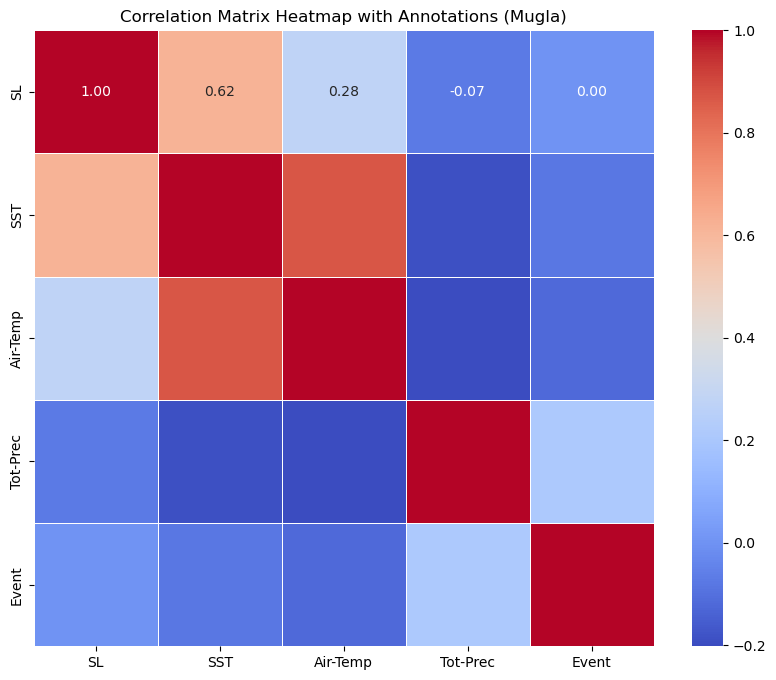

In [6]:
# Create a heatmap with annotations
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar=True)
plt.title("Correlation Matrix Heatmap with Annotations (Mugla)")
plt.show()

In [7]:
nans_by_col = df.isna().sum()
print("nans_by_col shape:", nans_by_col.shape)
nans_by_col.head()

nans_by_col shape: (5,)


SL          0
SST         0
Air-Temp    0
Tot-Prec    0
Event       0
dtype: int64

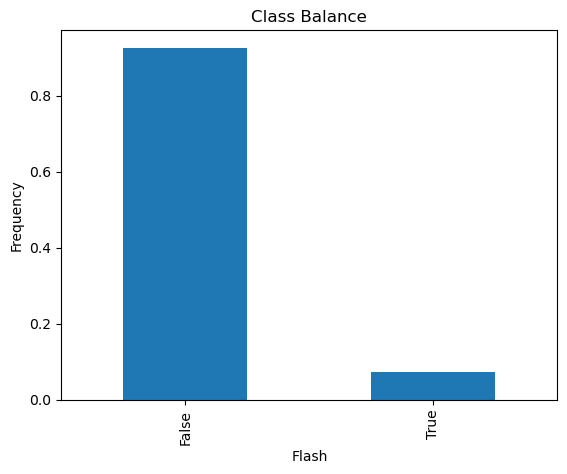

In [63]:
# Plot class balance
df['Event'].value_counts(normalize=True).plot(kind="bar");
plt.xlabel("Flash")
plt.ylabel("Frequency")
plt.title("Class Balance");

# Split

In [64]:
target = "Event"
X = df.drop(columns=target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (365, 4)
y shape: (365,)


In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.15, random_state=42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (310, 4)
y_train shape: (310,)
X_test shape: (55, 4)
y_test shape: (55,)


# Resample

In [66]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (576, 4)


SL        SST   Air-Temp  Tot-Prec
0  0.160962  20.140420  16.191889  2.764800
1  0.005639  17.227980  15.604364  0.000000
2  0.081347  17.598854  11.709803  0.000000
3  0.097371  19.375148  12.079889  9.084442
4 -0.030164  17.252441  17.304316  0.000000

# Build Model

In [67]:
clf = GradientBoostingClassifier()

## Cross Validation

In [68]:
cv_scores = cross_val_score(clf, X_train_over, y_train_over, cv=5, n_jobs=-1)
print(cv_scores)

[0.99137931 0.97391304 0.96521739 0.97391304 0.9826087 ]


In [69]:
params = {
    "n_estimators":range(20, 31, 5),
    "max_depth":range(2, 5)
}
params

{'n_estimators': range(20, 31, 5), 'max_depth': range(2, 5)}

## Create a GridSearchCV named model

In [70]:
model = GridSearchCV(clf, param_grid=params, cv=5, n_jobs=-1, verbose=1)

In [71]:
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(2, 5),
                         'n_estimators': range(20, 31, 5)},
             verbose=1)

## cross-validation results

In [72]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.024965      0.002342         0.002133        0.000491   
1       0.038141      0.006806         0.001904        0.000494   
2       0.040289      0.003396         0.003012        0.001057   
3       0.037316      0.002205         0.003011        0.000558   
4       0.045557      0.004058         0.002805        0.000676   

  param_max_depth param_n_estimators                                params  \
0               2                 20  {'max_depth': 2, 'n_estimators': 20}   
1               2                 25  {'max_depth': 2, 'n_estimators': 25}   
2               2                 30  {'max_depth': 2, 'n_estimators': 30}   
3               3                 20  {'max_depth': 3, 'n_estimators': 20}   
4               3                 25  {'max_depth': 3, 'n_estimators': 25}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0           0.775862           0.739130           0.791304           0.826087   
1           0.827586           0.739130           0.800000           0.826087   
2           0.836207           0.773913           0.808696           0.895652   
3           0.939655           0.869565           0.913043           0.904348   
4           0.956897           0.904348           0.913043           0.895652   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.739130         0.774303        0.033007                9  
1           0.747826         0.788126        0.037852                8  
2           0.782609         0.819415        0.043896                7  
3           0.939130         0.913148        0.025902                6  
4           0.939130         0.921814        0.022791                5

## best hyper-parameter

In [73]:
best_params = model.best_params_
print(best_params)

{'max_depth': 4, 'n_estimators': 30}


# Evaluate

In [78]:
acc_train = model.score(X_train_over, y_train_over)
acc_test = model.score(X_test, y_test)

print("Model Training Accuracy:", round(acc_train, 4))
print("Model Test Accuracy:", round(acc_test, 4))

Model Training Accuracy: 0.9896
Model Test Accuracy: 0.8909


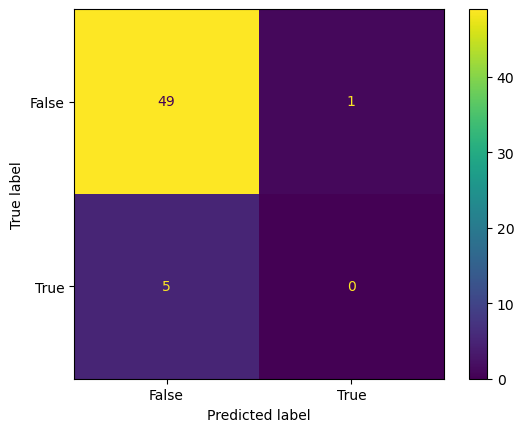

In [79]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

In [80]:
class_report = classification_report(y_test, model.predict(X_test))
print(class_report)

              precision    recall  f1-score   support

       False       0.91      0.98      0.94        50
        True       0.00      0.00      0.00         5

    accuracy                           0.89        55
   macro avg       0.45      0.49      0.47        55
weighted avg       0.82      0.89      0.86        55



# Communicate

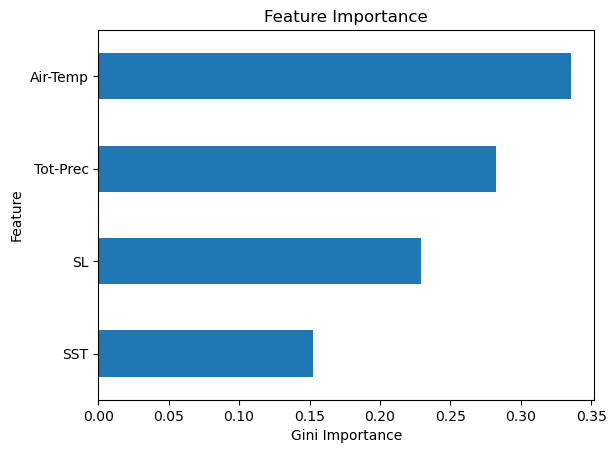

In [81]:
# Get feature names from training data
features = X_train_over.columns
# Extract importances from model
importances = model.best_estimator_.feature_importances_

# Create a series with feature names and importances
feat_imp = feat_imp = pd.Series(importances, index=features).sort_values()

# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

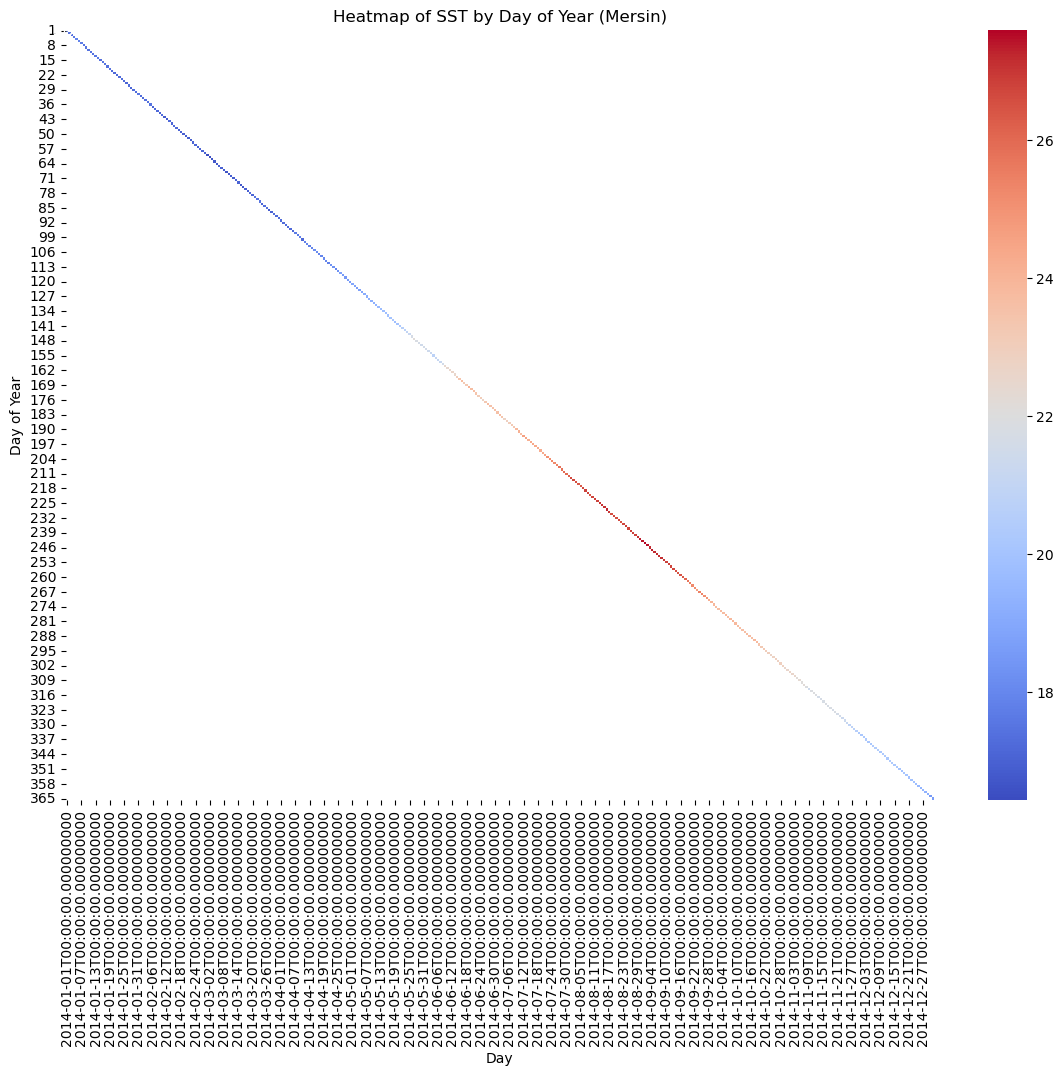

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pivot the data to create a matrix for the heatmap
df_pivot = df.pivot_table(values='SST', index=df.index.dayofyear, columns='Date')

plt.figure(figsize=(14, 10))
sns.heatmap(df_pivot, cmap='coolwarm', annot=True, fmt=".1f")
plt.title('Heatmap of SST by Day of Year (Mersin)')
plt.xlabel('Day')
plt.ylabel('Day of Year')
plt.show()


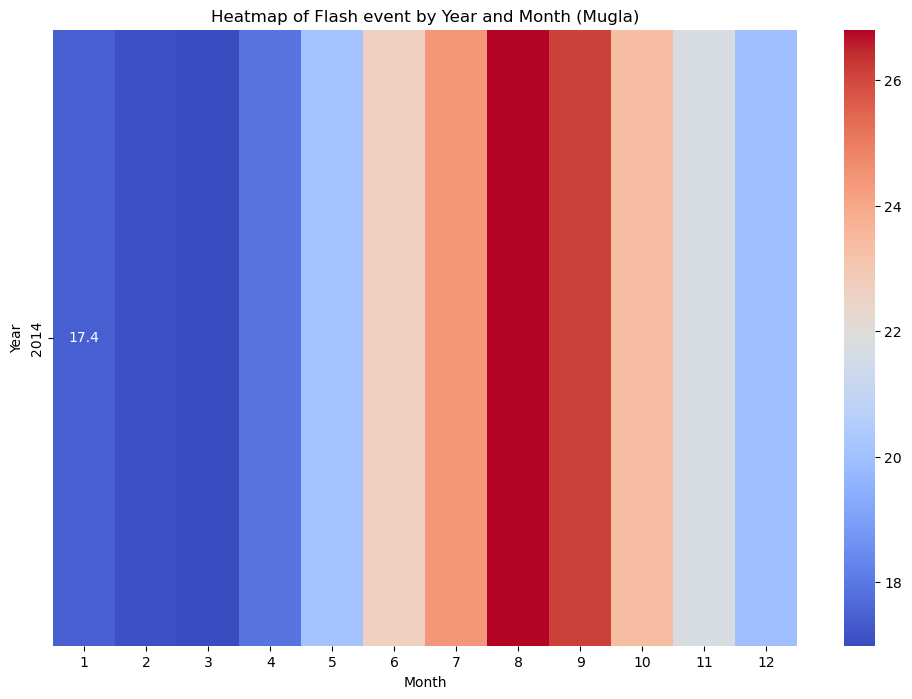

In [15]:
# Pivot the data to create a matrix for the heatmap
df_pivot = df.pivot_table(values='SST', index=df.index.year, columns=df.index.month)

plt.figure(figsize=(12, 8))
sns.heatmap(df_pivot, cmap='coolwarm', annot=True, fmt=".1f")
plt.title('Heatmap of Flash event by Year and Month (Mugla)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()